# Stable Diffusion Dreambooth Token Checker

Adapted from scripts and ideas by 2kpr

https://www.reddit.com/r/StableDiffusion/comments/zc65l4/rare_tokens_for_dreambooth_training_stable/<br>
https://github.com/2kpr/dreambooth-tokens<br>
https://arxiv.org/pdf/2208.12242<br><br>
Join The [Stable Diffusion Dreambooth Discord Server](https://discord.gg/wNNs2JNF7G)<br>
Medium Article : [Good Token, Bad Token](https://medium.com/@yushantripleseven/good-token-bad-token-1d66891b0b0a)</br>

**Purpose:** To check what a given token / token+class pair might generate from the model you are planning to train on. It will also show a breakdown of how your token is tokenized into subwords. So that long, convoluted token you came up with might actually be broken up into subtokens which are very common words themselves and so having a very strong prior association in the model.

There is no rule to say you can't just use someone's regular name. You can use `tomcruise` if you want but you'll just end up pulling weights associated with him to the subject you are training and erasing old tomcruise from the model's memory.

A 3x3 grid of images will be generated from prompts using token(s) you specify.  You can also include class words so that each token will be paired with the selected class(es) which will also be added to the list.

### What to look for:

* If outputs show a consistent theme, then the token you are using probably already has strong associations in the model. (not ideal)
* If outputs appear random then it will probably have weaker associations in the model. (better)


In [ ]:
#@title 1. Install Requirements

print("This will take a couple of minutes...")
!pip install -q --upgrade diffusers[torch]
#!pip install -q xformers==0.0.16
!pip install -q xformers==0.0.17
!pip install -q transformers
!pip install -q triton

# =========================================================================================
# Get Font
# =========================================================================================
import os
from os.path import exists
if exists('inconsolata.regular.ttf')==False:
  !wget 'https://github.com/yushan777/stable-diffusion-token-checker/raw/main/inconsolata.regular.ttf'

# =========================================================================================
# Image Output dir
# =========================================================================================
OUTPUT_DIR = "output"
if exists(OUTPUT_DIR)==False:
    os.mkdir(OUTPUT_DIR)

import shutil
from IPython.display import clear_output

print("Finished installing requirements.")

In [3]:
#@title 2. Select Model & Init Pipeline
# =========================================================================================
# SETUP SD PIPELINE
# =========================================================================================
import torch
import xformers
from diffusers import StableDiffusionPipeline, AutoencoderKL, DDIMScheduler

if torch.cuda.is_available():
    torch.cuda.empty_cache()


SELECT_MODEL = 'Stable Diffusion 1.5' #@param ["Stable Diffusion 1.5", "Stable Diffusion 2.1"]

# can be local paths also
if SELECT_MODEL=='Stable Diffusion 1.5':
  MODEL_PATH = "runwayml/stable-diffusion-v1-5"
  VAE_PATH = "stabilityai/sd-vae-ft-mse"
  pipe = StableDiffusionPipeline.from_pretrained(f'{MODEL_PATH}',
                                               vae = AutoencoderKL.from_pretrained(f'{VAE_PATH}', torch_dtype = torch.float16),
                                               variant="fp16",
                                               torch_dtype = torch.float16)
elif SELECT_MODEL=='Stable Diffusion 2.1':
  MODEL_PATH = "stabilityai/stable-diffusion-2-1"
  pipe = StableDiffusionPipeline.from_pretrained(f'{MODEL_PATH}',
                                               variant="fp16",
                                               torch_dtype = torch.float16)



pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

# =========================================================================================
# Copy the vocab.json from the cache to current dir
# =========================================================================================
# tokenizer/vocab.json files are normally saved in cache e.g.
# /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/xxxxx/tokenizer/vocab.json

name = 'vocab.json'
init_path = '/root/.cache/'
result = []
for root, dirs, files in os.walk(init_path):
  if name in files:
    result.append(os.path.join(root, name))

for cached_vocab_path in result:
  print('-> ' + cached_vocab_path)

  #split the cached dir path
  dirs_list = cached_vocab_path.split('/')
  # get repo name without username
  HF_repo_name = MODEL_PATH.split('/')

  #build dir path to copy vocab to
  copy_to_dir = 'dictionary/' + HF_repo_name[1] + '/' + dirs_list[8] + '/' + dirs_list[9]

  # create target dir if not exist
  os.makedirs(os.path.dirname(copy_to_dir), exist_ok=True)
  #copy
  shutil.copy(cached_vocab_path, copy_to_dir)

  #Set var
  vocab_file_path = copy_to_dir

print("Finished.")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


-> /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9/tokenizer/vocab.json
Finished.


In [2]:
#@title 3. Setup Functions

# ======================================================================================
# DEFINE FUNCTIONS
# ======================================================================================

#@title 2. Define Functions
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from transformers import CLIPTokenizer, CLIPModel
import json

split_positions = []
image_width_height = 512
grid_rows = 3
grid_cols = 3
grid_width = image_width_height * grid_cols
myFont = ImageFont.truetype("inconsolata.regular.ttf", size=35)

# ===========================================================================
# ===========================================================================
def tokenize(token):

  with open(vocab_file_path, "r", encoding='utf-8') as f:
    vocab = json.load(f)
    vocab = {v: k for k, v in vocab.items()}

  tokenizer = CLIPTokenizer.from_pretrained(MODEL_PATH, subfolder="tokenizer",revision="fp16")

  #inputs = tokenizer(sys.argv[1], padding=True)
  inputs = tokenizer(f'{token}', padding=True)
  value = sum(inputs["input_ids"])
  value_str = str(value)
  token_data = ''

  # holds lines of sub-tokens up to the width of the grid (minus margin)
  return_list = []
  margin_right = 256

  # add current string to list
  #return_list.append(token_data)
  #token_data = '' # reset


  token_count = 0
  for x in range(len(inputs["input_ids"])):
    #print(vocab[inputs["input_ids"][x]] + " " + str(inputs["input_ids"][x]))

    # don't include <|startoftext|> 49406 or <|endoftext|> 49407
    if inputs["input_ids"][x] != 49406 and inputs["input_ids"][x] != 49407:
      # add next sub-token
      token_data += '[' + vocab[inputs["input_ids"][x]] + ']'
      token_count += 1
      # check string length, if >= grid_width
      if (get_text_size(token_data, myFont)[0] + margin_right) >= grid_width:
        return_list.append(token_data.strip())
        token_data = '' #reset string
      if x < len(inputs["input_ids"]) - 2:
        token_data += ' '

  # add last or only string
  if len(token_data.strip()) > 0:
    return_list.append(token_data.strip())

  print(return_list)
  print("Token Count = " + f'{token_count}')


  return return_list, token_count

# ===========================================================================
# ===========================================================================
def generate_grid(seed, steps, preview_scale):

  if steps == 0: steps = 20

  # read word list from file
  #with open("4tokens_short.txt", "r", encoding="utf-8") as f:
  #	tokenList = [line.strip() for line in f.readlines()]

  # =============================================================
  print("start")

  text_height = get_text_size('hello', myFont)[1] # get height of text for this font - string is not important
  titlebar_height = 64
  line_padding = 5
  text_height += line_padding

  # for each token...
  for token in token_list:

    token_data = tokenize(token)
    token_data_lines = token_data[0]
    token_count = token_data[1]

    titlebar_height = text_height * (len(token_data_lines)+2) #+2 for the Token and Token Count lines
    titlebar_height += line_padding * 2 # add extra padding so it's not too tight

    # set generator
    generator_cuda = torch.Generator(device="cuda")

    # init grid image obj.
    grid = Image.new('RGB', size=(grid_cols*image_width_height, (grid_rows*image_width_height)+titlebar_height))

    seed_list = [] #
    with torch.autocast("cuda"), torch.inference_mode():
      for i in range(9):
        if seed == -1: # random seed
          current_seed = generator_cuda.seed()
        else: # fixed seed : add loop counter
          current_seed = seed + i
          generator_cuda.manual_seed(current_seed)

        seed_list.append(current_seed) # add to list
        print(f'seed : {current_seed}')

        image = pipe(token, generator=generator_cuda, num_inference_steps=steps, num_images_per_prompt=1).images[0]
        grid.paste(image, box=(i%grid_cols*image_width_height, (i//grid_cols*512)+titlebar_height))

    # Call draw Method
    draw = ImageDraw.Draw(grid)

    # Add Text to grid
    x = 10
    y = 0
    draw.text((x, y), f'Token: {token}', font=myFont, fill=(255, 255, 255))
    y += text_height
    draw.text((x, y), f'Token Count = {token_count}', font=myFont, fill=(255, 255, 255))
    y += text_height
    for line in token_data_lines:
      draw.text((x, y), line, font=myFont, fill=(255, 255, 255))
      y += text_height

    # since quality is not a priority we will save in jpg with some compression
    # to keep filesizes small and faster loading.
    filename = token
    if token ==' ' or token == '':
      filename = 'empty'

    grid.save(OUTPUT_DIR + "/" + filename + ".jpg", optimize=True, quality=60)

    #image = Image.open(f'{grid}')
    display(grid.resize(( int(grid.width * preview_scale), int(grid.height * preview_scale))))

# ===========================================================================
# ===========================================================================
def get_text_size(text_string, font):
  # https://stackoverflow.com/a/46220683/9263761
  ascent, descent = font.getmetrics()
  text_width = font.getmask(text_string).getbbox()[2]
  text_height = font.getmask(text_string).getbbox()[3] + descent
  #print("text length = " + str(text_width) )
  return (text_width, text_height)


In [6]:
#@title 4. Token / Class Words
#@markdown add your token words you would like to test (comma separated)
TOKENS = "sks" #@param {type:"string"}


delimeter = ''
if ',' in TOKENS:
    delimeter = ','
else:
    delimeter = ' ' #this will also clear empty strings

# split and remove any whitespaces
token_list = [x.strip() for x in TOKENS.split(delimeter)]

#for t in token_list:
# print(t)

#@markdown ___

#@markdown (Optional) add class to the list?

class_person = True #@param {type:"boolean"}
class_man = True #@param {type:"boolean"}
class_woman = True #@param {type:"boolean"}
class_artstyle = False #@param {type:"boolean"}
class_other = "" #@param {type:"string"}

token_and_person_list = []
token_and_man_list = []
token_and_woman_list = []
token_and_artstyle_list = []
token_and_other_list = []
# =============================================
if class_person==True:
  for t in token_list:
    token_and_person_list.append(f'{t} person')

# =============================================
if class_man==True:
  for t in token_list:
    token_and_man_list.append(f'{t} man')

# =============================================
if class_woman==True:
  for t in token_list:
    token_and_woman_list.append(f'{t} woman')

# =============================================
if class_artstyle==True:
  for t in token_list:
    token_and_artstyle_list.append(f'{t} artstyle')

# =============================================
if len(class_other) > 0 :
  for t in token_list:
    token_and_other_list.append(f'{t} {class_other}')

# add token+class to original list
token_list.extend(token_and_person_list)
token_list.extend(token_and_man_list)
token_list.extend(token_and_woman_list)
token_list.extend(token_and_artstyle_list)
token_list.extend(token_and_other_list)


for t in token_list:
    print(t)
#@markdown For every token in your list, the class word will be appended to that token and added to the list. \
#@markdown Ex. If you have `'wow, owo, sks'` in your list, and select `'person'` class, then the list would become:
#@markdown * wow
#@markdown * owo
#@markdown * sks
#@markdown * wow person
#@markdown * owo person
#@markdown * sks person
# add class word variant to list?


gulo
gulo person
gulo man
gulo woman


start
['[gu] [lo</w>]']
Token Count = 2
seed : 8310675010021283


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 2896888589208680


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 2303952757295996


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 4380607978455252


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 5635292919863749


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 1797288214503658


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 5461209238407350


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 4924455281787300


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 3389073823118040


  0%|          | 0/18 [00:00<?, ?it/s]

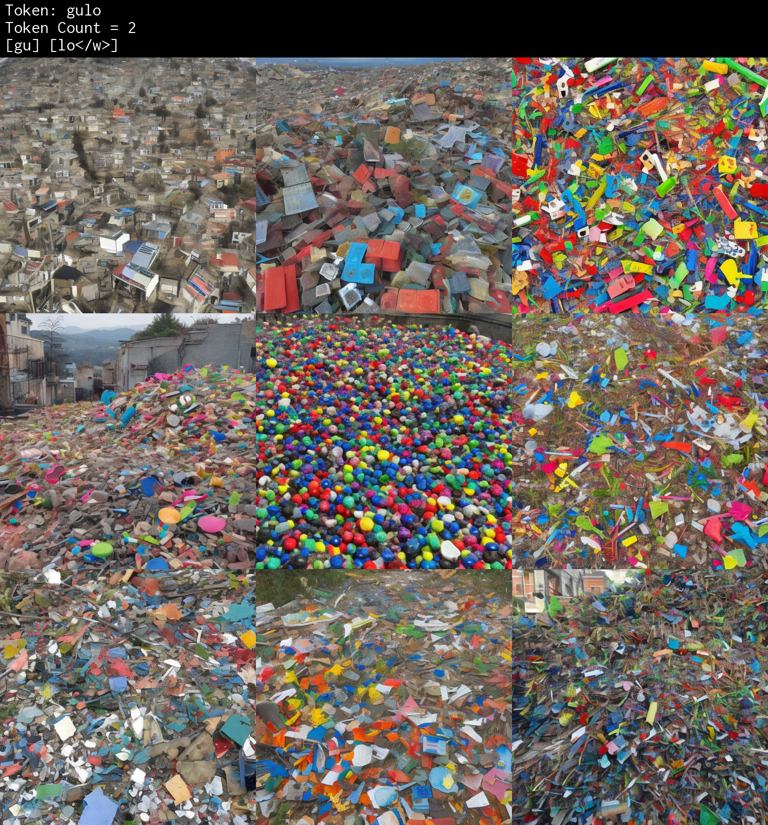

['[gu] [lo</w>] [person</w>]']
Token Count = 3
seed : 4275094593741413


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 2822579038218086


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 1708421697994798


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 740028959265166


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 738685797190124


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 4141465865200114


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 4637098835483562


  0%|          | 0/18 [00:00<?, ?it/s]

seed : 5810586939850086


  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
#@title 5. Generate!


seed = -1 #@param {type:"number"}
steps = 18 #@param {type:"slider", min:1, max:30, step:1}
preview_grid_scale = 0.5 #@param {type:"slider", min:0.1, max:1, step:0.1}

if seed > 9223372036854775807:
  print("seed value too big.")
else:
  #print(int(steps))
  #print(preview_grid_size/100)
  generate_grid(seed, steps, preview_grid_scale)

  print("grids saved in 'output' directory")

In [ ]:
#@title 6. Display Images Results
from PIL import Image
from IPython.display import display
import glob

print("These images will be half size. To get full-size images, set scale to 1.0 or download directly from the folder")
scale = 0.5

#get all images in the output folder

img_list = glob.glob(f'{OUTPUT_DIR}/*.jpg')

for img in img_list:
  print("\n\n" + img)
  image = Image.open(f'{img}')
  display(image.resize(( int(image.width * scale), int(image.height * scale))))


In [ ]:
#@title 6. Save All Grid Images To Zip Archive
# for downloading or moving to your google drive
import shutil
from google.colab import drive

ARCHIVE_NAME = "" #@param {type:"string"}
#@markdown leave empty for default name.

if len(ARCHIVE_NAME)==0:
  ARCHIVE_NAME = 'token_grids'

archive_path = shutil.make_archive(ARCHIVE_NAME, 'zip', OUTPUT_DIR)

# Copy to google drive?
COPY_TO_GOOGLE_DRIVE = True #@param {type:"boolean"}

if COPY_TO_GOOGLE_DRIVE:
  google_drive_dir = '/content/drive'

  if path.exists(google_drive_dir)==False:
    drive.mount(google_drive_dir)
  else:
    print(f'Google Drive already mounted at {google_drive_dir}')
    # drive.mount('/content/drive')

  shutil.copy(archive_path, google_drive_dir + '/MyDrive')
  print("Archive copied to "+ google_drive_dir + '/MyDrive/'+ ARCHIVE_NAME + '.zip')

In [ ]:
#@title Delete images from dir /content/output
import os, shutil

dir = "/content/output"

#!rm -rf "$dir"

for filename in os.listdir(dir):
    file_path = os.path.join(dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

print("you may need to refresh the file manager view if the files is still visible after deleting.")
